In [2]:
from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker

import seaborn as sns


from global_config import config
import pandas as pd
import numpy as np
import rpy2
import os

from datetime import date, timedelta


data_dir_mnps   = config.get_property('geo_dir')
data_dir        = config.get_property('data_dir')
fb_ppl_data     = config.get_property('covid_fb')
results_dir     = config.get_property('results_dir')
data_cases_path = os.path.join(fb_ppl_data, 'agglomerated', 'geometry')


In [7]:

# Defines lockdowns
no_lock_lab = "No Lockdown Imposed"
lock_lab    = "Lockdown Imposed"


lockdowns = []
lockdowns.append({"code": "A",
                  "start_date" : pd.to_datetime("2020-07-13"),
                  "end_date"   : pd.to_datetime("2020-07-23"),
                  "places":["chapinero",
                            "los_martires",
                            "san_cristobal",
                            "tunjuelito",
                            "rafel_uribe_uribe",
                            "ciudad_bolivar",
                            "santa_fe",
                            "usme"]})

lockdowns.append({"code": "B",
                  "start_date" : pd.to_datetime("2020-07-23"),
                  "end_date"   : pd.to_datetime("2020-08-06"),
                  "places":["bosa",
                            "antonio_narino",
                            "kennedy",
                            "puente_aranda",
                            "fontibon"]})

lockdowns.append({"code": "C",
                  "start_date" : pd.to_datetime("2020-07-31"),
                  "end_date"   : pd.to_datetime("2020-08-14"),
                  "places":["suba",
                            "engativa",
                            "barrios_unidos"]})

lockdowns.append({"code": "D",
                  "start_date" : pd.to_datetime("2020-08-16"),
                  "end_date"   : pd.to_datetime("2020-08-27"),
                  "places":["usaquen",
                            "chapinero",
                            "santa_fe",
                            "candelaria",
                            "teusaquillo",
                           "puente_aranda",
                           "antonio_narino"]})


In [12]:
dict_correct = {'Los Martires': 'Los Mártires', 'Fontibon': 'Fontibón', 'Engativa': 'Engativá',
                            'San Cristobal': 'San Cristóbal', 'Usaquen': 'Usaquén',
                            'Ciudad Bolivar': 'Ciudad Bolívar', 'Candelaria': 'La Candelaria'}

# load Rt locality estimates
cases_df = pd.read_csv(os.path.join(data_cases_path, 'cases.csv'), parse_dates=["date_time"])


cases_df["poly_id"]  = cases_df["poly_id"].apply(lambda s:   s.replace("colombia_bogota_localidad_",""))

cases_df["poly_name"]  = cases_df["poly_id"].apply(lambda s:   ' '.join( [word.capitalize() for word in s.replace("colombia_bogota_localidad_","").split('_') ] ) )
cases_df["poly_name"]  = cases_df["poly_name"].replace( dict_correct )

cases_bog_df = cases_df.groupby(['poly_id', 'poly_name', 'date_time']).sum()[["num_cases", "num_diseased", "num_infected_in_icu"]]
cases_bog_df = cases_bog_df.unstack([0,1]).resample('1D').sum().stack().stack().reset_index().rename(columns={'date_time':'date','num_cases': 'confirm',
                                                                                                                'num_diseased': 'deaths',
                                                                                                                'num_infected_in_icu': 'icu'})


rt_df_all = []
path_to_save = results_dir

for poly_name in cases_bog_df["poly_id"].unique():
    rt_loc = pd.read_csv(os.path.join(path_to_save, 'rt', 'rt_df_{}_confirmation.csv'.format(poly_name)))
    rt_loc["location_id"] = poly_name
    rt_loc = rt_loc[rt_loc.type=='estimate']
    rt_loc = rt_loc[rt_loc.variable=='R']
    rt_loc['date'] = rt_loc['date'].map(lambda x: pd.to_datetime(0)+timedelta(days=x))
    rt_loc = rt_loc.drop(columns=['Unnamed: 0'])
    rt_df_all.append(rt_loc)

rt_df_all = pd.concat(rt_df_all)
rt_df_all


,date,variable,strat,type,median,mean,sd,lower_90,lower_50,lower_20,upper_20,upper_50,upper_90,location_id
0,2020-03-14,R,NA_character_,estimate,1.776741,1.788429,0.164820,1.531016,1.680119,1.739704,1.820044,1.892763,2.079742,antonio_narino
1,2020-03-15,R,NA_character_,estimate,1.699241,1.707016,0.150385,1.476043,1.605850,1.663997,1.733912,1.801143,1.960841,antonio_narino
2,2020-03-16,R,NA_character_,estimate,1.616431,1.624819,0.144584,1.407748,1.525607,1.583536,1.654101,1.716474,1.870811,antonio_narino
3,2020-03-17,R,NA_character_,estimate,1.536636,1.543448,0.143658,1.322035,1.441880,1.500192,1.573392,1.633716,1.794197,antonio_narino
4,2020-03-18,R,NA_character_,estimate,1.457039,1.464396,0.144341,1.235902,1.363457,1.422957,1.494264,1.555988,1.716472,antonio_narino
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,2021-04-14,R,NA_character_,estimate,0.512427,0.513533,0.046124,0.439498,0.481247,0.501368,0.524696,0.545360,0.589619,usme
397,2021-04-15,R,NA_character_,estimate,0.469276,0.470670,0.048098,0.394049,0.437357,0.457306,0.482133,0.504178,0.550368,usme
398,2021-04-16,R,NA_character_,estimate,0.431838,0.433195,0.050039,0.353642,0.398515,0.419064,0.444571,0.468408,0.516545,usme
399,2021-04-17,R,NA_character_,estimate,0.399098,0.400776,0.051964,0.319283,0.364770,0.386441,0.412151,0.437311,0.487248,usme


In [33]:
# prelockdown period
pre_lockdown_start = pd.to_datetime("2020-06-20")
pre_lockdown_end   = pd.to_datetime("2020-07-12")

lockdown_start     = pd.to_datetime("2020-07-13")
lockdown_end       = pd.to_datetime("2020-08-27")

# poslockdown period
pos_lockdown_start = pd.to_datetime("2020-08-28")
pos_lockdown_end   = pd.to_datetime("2020-09-15")


# Assigns moments
rt_df_all.loc[(rt_df_all.date <= pre_lockdown_end)
            & (rt_df_all.date >= pre_lockdown_start),'lockdown_type'] = "pre-lockdown1"

rt_df_all.loc[(rt_df_all.date <= lockdown_end)
            & (rt_df_all.date >= lockdown_start),'lockdown_type'] = "lockdown1"

rt_df_all.loc[(rt_df_all.date <= pos_lockdown_end)
            & (rt_df_all.date >= pos_lockdown_start),'lockdown_type'] = "pos-lockdown1"


rt_df_all["lockdown_group"] = 'None'
rt_df_all["locked_down"]    = False

for lock_info in lockdowns:
    g_lockdown_start     = lock_info["start_date"]
    g_lockdown_end       = lock_info["end_date"]
    rt_df_all.loc[ (rt_df_all.date <= g_lockdown_end)
                    & (rt_df_all.date >= g_lockdown_start), 'lockdown_group'] += "-"+lock_info["code"]


    rt_df_all.loc[ (rt_df_all.date <= g_lockdown_end)
                    & (rt_df_all.date >= g_lockdown_start) & (rt_df_all.location_id.isin(lock_info["places"]) ), 'locked_down'] = True

rt_df_all["lockdown_group"] = rt_df_all["lockdown_group"].map(lambda x: x.split('-')[-1])

rt_pivoted_loc_df = pd.pivot_table(rt_df_all, values='median', index=['date', 'lockdown_type', 'lockdown_group', "locked_down"], columns=['location_id']).fillna(0).reset_index()
rt_loc_df         = pd.pivot_table(rt_df_all, values='median', index=['date', 'location_id', 'lockdown_type', 'lockdown_group', "locked_down"], columns=['variable']).fillna(0).reset_index()


In [54]:
rt_loc_df["location_id"] = rt_loc_df["location_id"].apply(lambda s: ' '.join( [word.capitalize() for word in s.split('_') ] ) )

pre_lockdown_df = rt_loc_df[ rt_loc_df["lockdown_type"] == 'pre-lockdown1' ]
A_lockdown_df   = rt_loc_df[ rt_loc_df["lockdown_group"].isin( ['A'] ) ]
B_lockdown_df   = rt_loc_df[ rt_loc_df["lockdown_group"].isin( ['B'] ) ]
C_lockdown_df   = rt_loc_df[ rt_loc_df["lockdown_group"].isin( ['C'] ) ]
D_lockdown_df   = rt_loc_df[ rt_loc_df["lockdown_group"].isin( ['D'] ) ]
pos_lockdown_df = rt_loc_df[ rt_loc_df["lockdown_type"] == 'pos-lockdown1' ]


/Users/chaosdonkey06/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/chaosdonkey06/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


variable,date,location_id,lockdown_type,lockdown_group,locked_down,R,group
0,2020-06-20,Antonio narino,pre-lockdown1,None,False,1.137485,Pre-lockdown
1,2020-06-20,Barrios unidos,pre-lockdown1,None,False,1.267941,Pre-lockdown
2,2020-06-20,Bosa,pre-lockdown1,None,False,1.135954,Pre-lockdown
3,2020-06-20,Candelaria,pre-lockdown1,None,False,0.987836,Pre-lockdown
4,2020-06-20,Chapinero,pre-lockdown1,None,False,1.278688,Pre-lockdown
...,...,...,...,...,...,...,...
1667,2020-09-15,Suba,pos-lockdown1,None,False,1.146986,Pos-lockdown
1668,2020-09-15,Teusaquillo,pos-lockdown1,None,False,1.186848,Pos-lockdown
1669,2020-09-15,Tunjuelito,pos-lockdown1,None,False,1.001981,Pos-lockdown
1670,2020-09-15,Usaquen,pos-lockdown1,None,False,1.184380,Pos-lockdown


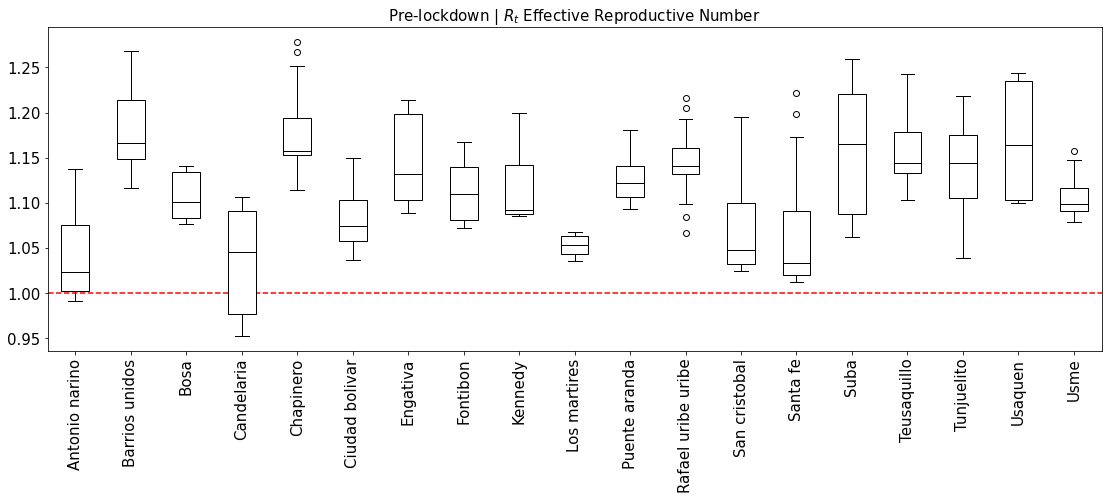

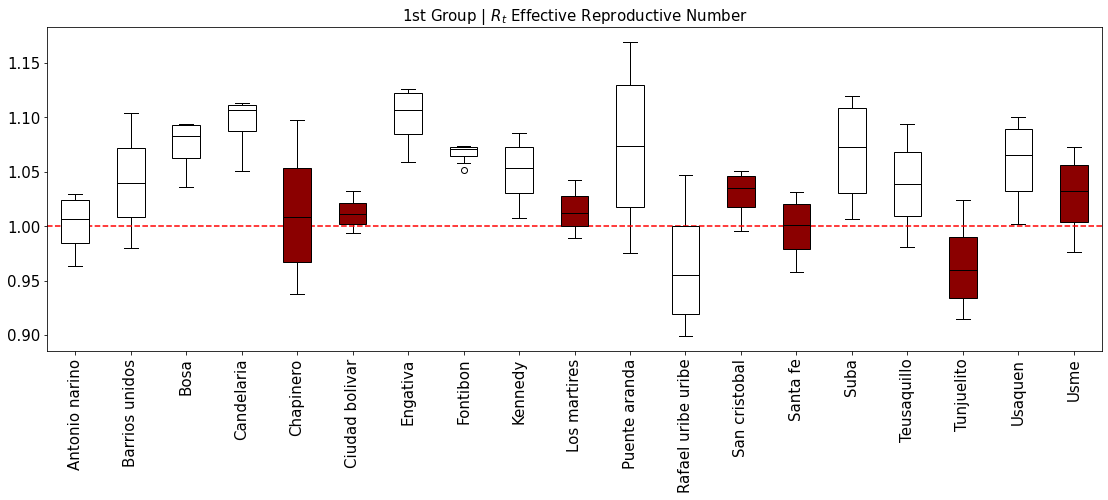

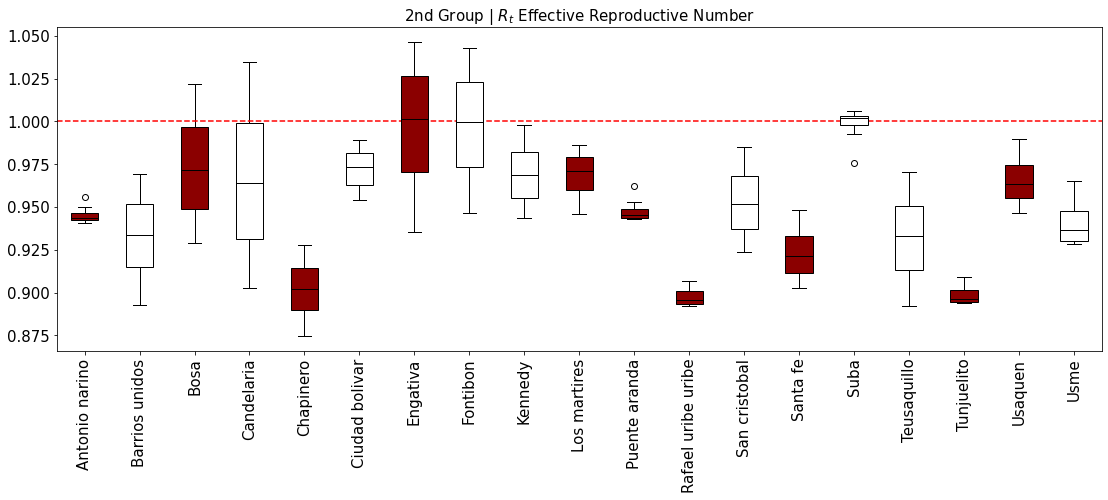

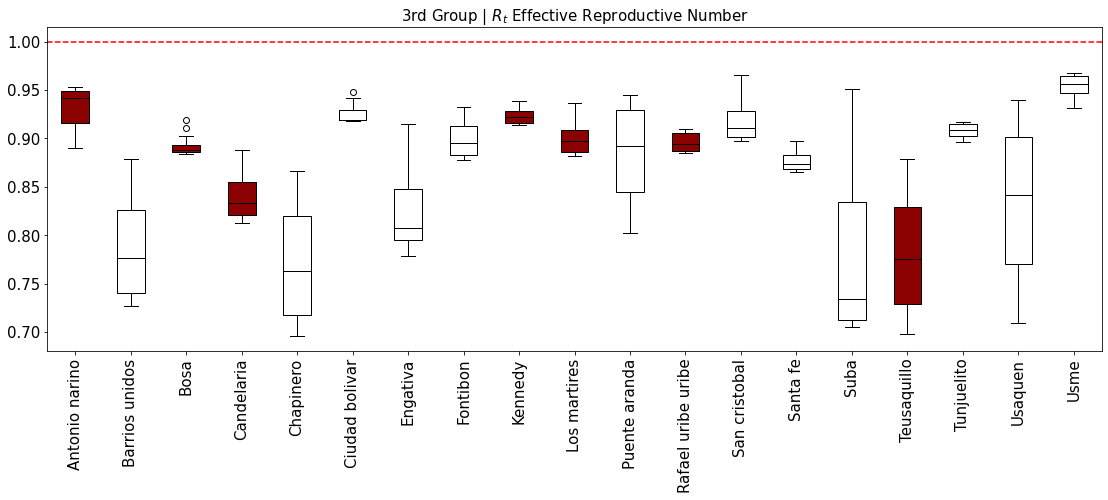

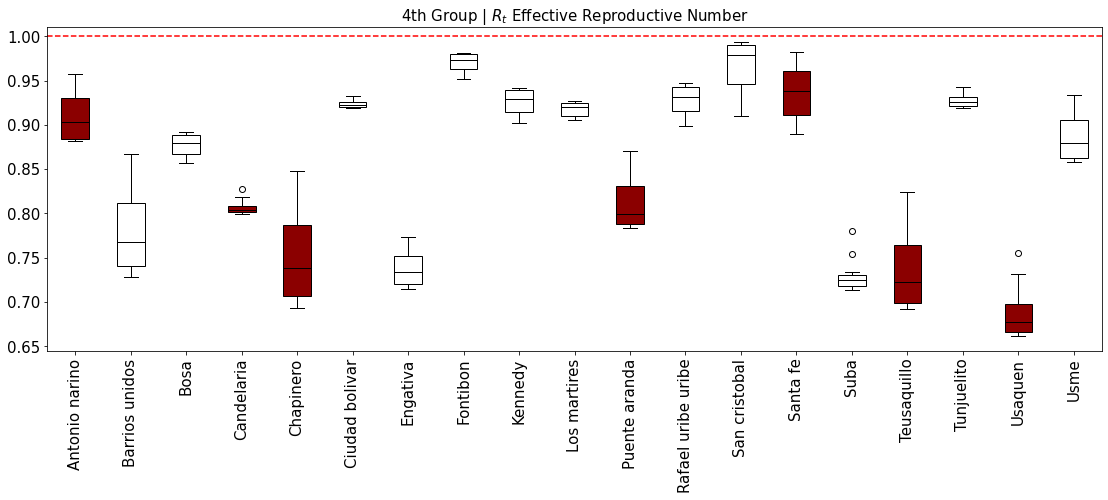

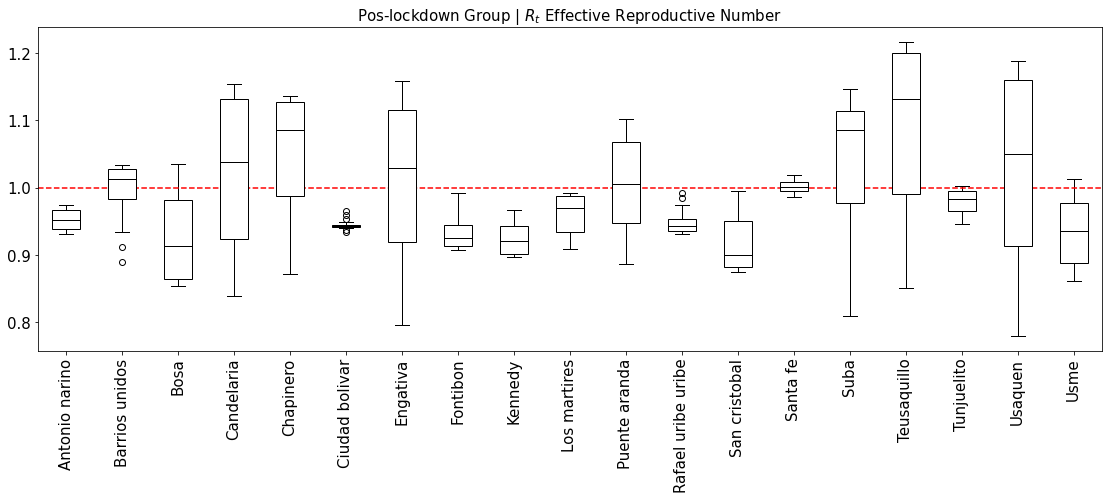

In [81]:
import matplotlib
def plot_rt_movement(df_rt, title='', path_to_save=None):
    colors = df_rt[["location_id", "lockdown_group", "locked_down"]].drop_duplicates().sort_values(by='location_id')

    fig, ax = plt.subplots(1, 1, figsize=(15.5, 7.2), sharey=False)
    boxplot = df_rt[['location_id', 'R']].boxplot(ax=ax, by='location_id', grid=False, rot=90, fontsize=15, color='k', layout=(2, 1), patch_artist=True)
    boxplot.set_title(rf'{title} | $R_t$ Effective Reproductive Number', fontsize=15)
    boxplot.get_figure().suptitle(None)
    ax.axhline(y=1, color='red', linestyle='--')
    ax.set_xlabel(None)
    for b in [boxplot]:
        for idx, p in enumerate( b.findobj(matplotlib.patches.Patch) ): # [3:5].set_facecolor("blue")
            if idx>len(colors)-1:
                break
            if colors.iloc[idx]["locked_down"]:
                p.set_facecolor("darkred")

            else:
                p.set_facecolor("white")

    plt.tight_layout()
    if path_to_save:
        fig.savefig(path_to_save, dpi=300,  bbox_inches='tight', transparent=False)

os.mkdir(os.path.join(results_dir, 'rt_localities'))
plot_rt_movement(pre_lockdown_df, title='Pre-lockdown',   path_to_save=os.path.join(results_dir, 'rt_localities', 'rt_pre.png') )
plot_rt_movement(A_lockdown_df,   title='1st Group',      path_to_save=os.path.join(results_dir, 'rt_localities', 'rt_A1.png') )
plot_rt_movement(B_lockdown_df,   title='2nd Group',      path_to_save=os.path.join(results_dir, 'rt_localities', 'rt_B1.png') )
plot_rt_movement(C_lockdown_df,   title='3rd Group',      path_to_save=os.path.join(results_dir, 'rt_localities', 'rt_C1.png') )
plot_rt_movement(D_lockdown_df,   title='4th Group',      path_to_save=os.path.join(results_dir, 'rt_localities', 'rt_D1.png') )
plot_rt_movement(pos_lockdown_df, title='Pos-lockdown Group',    path_to_save=os.path.join(results_dir, 'rt_localities', 'rt_pos.png') )



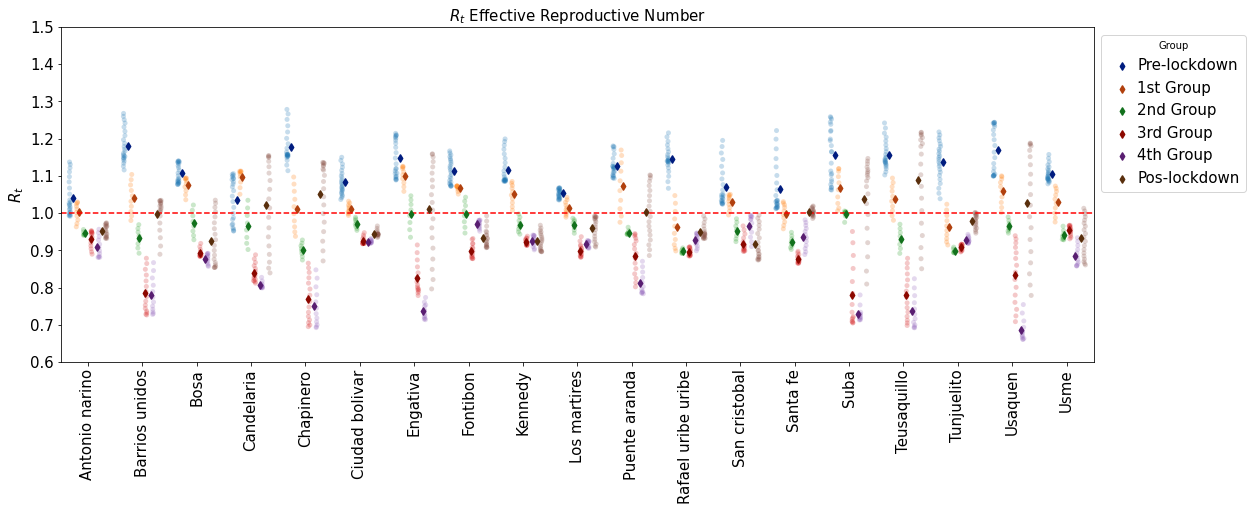

/Users/chaosdonkey06/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


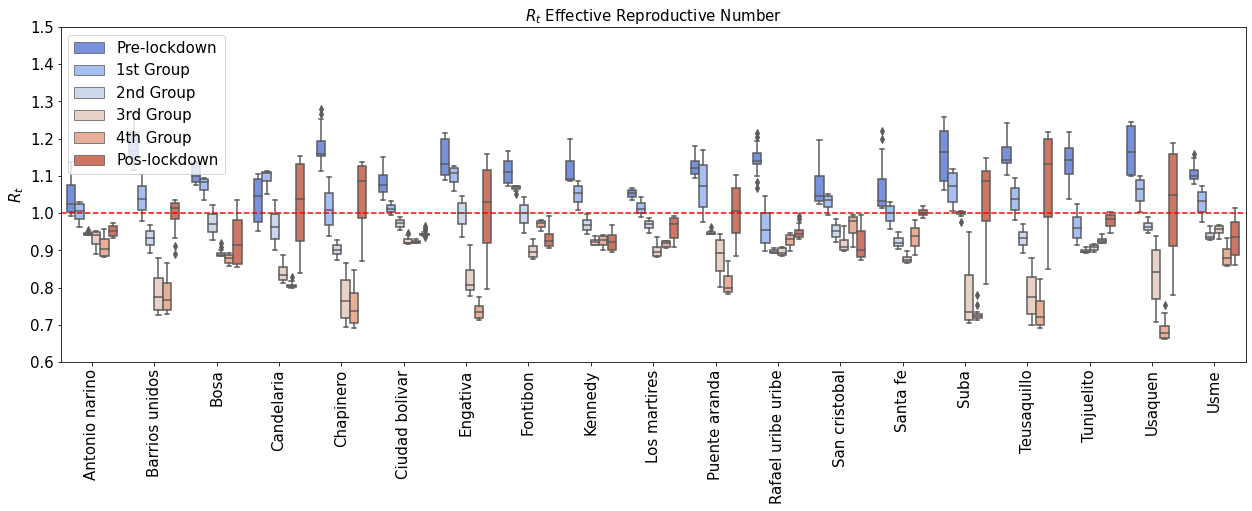

In [83]:
import seaborn as sns

pre_lockdown_df.loc[:, "group"]  = 'Pre-lockdown'
A_lockdown_df.loc[:, "group"]    = '1st Group'
B_lockdown_df.loc[:, "group"]    = '2nd Group'
C_lockdown_df.loc[:, "group"]    = '3rd Group'
D_lockdown_df.loc[:, "group"]    = '4th Group'
pos_lockdown_df.loc[:, "group"]  = 'Pos-lockdown'

box_plot_rt_df = pd.concat([pre_lockdown_df, A_lockdown_df, B_lockdown_df, C_lockdown_df, D_lockdown_df, pos_lockdown_df])

fig, ax = plt.subplots(1,1,figsize=(17.5, 7.2))
# Draw a nested boxplot to show bills by day and time

sns.boxplot(ax=ax, data=box_plot_rt_df, x="location_id", y="R", hue="group", palette='coolwarm')

ax.set_title(r'$R_t$ Effective Reproductive Number', fontsize=15)
ax.axhline(y=1, color='red', linestyle='--')
ax.tick_params(axis='both', labelsize=15)
ax.set_ylabel(r'$R_t$', fontsize=15)
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylim([0.6, 1.5])
ax.legend(fontsize=15, loc='upper left')
ax.set_xlabel(None)
plt.tight_layout()

fig.savefig(os.path.join(results_dir, 'rt_localities', 'rt_all_boxplot.png'), dpi=300,  bbox_inches='tight', transparent=False)


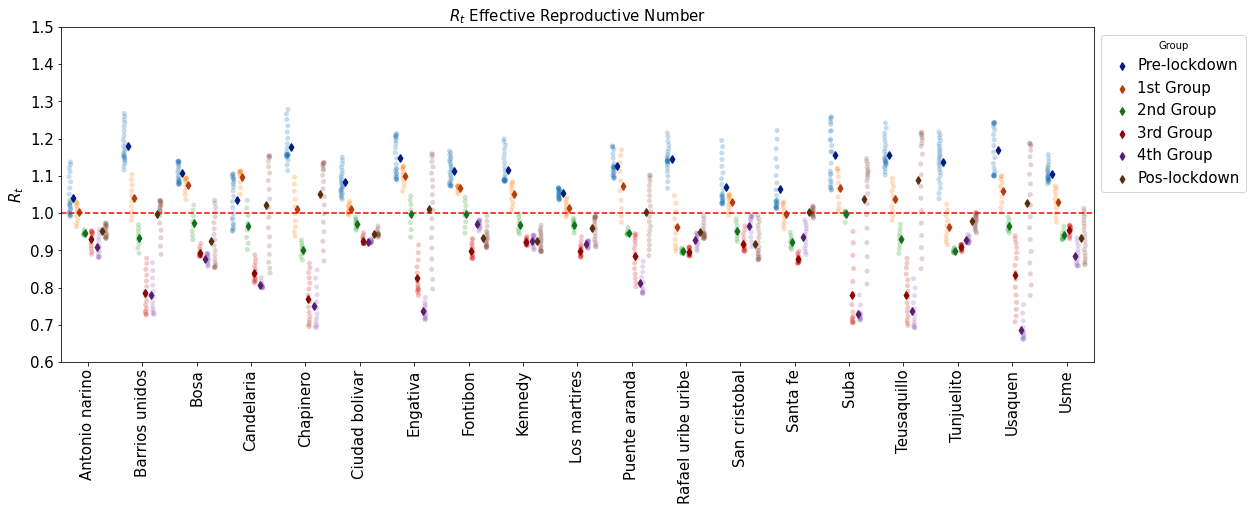

In [362]:
fig, ax = plt.subplots(1,1,figsize=(17.5, 7.2))

# Show each observation with a scatterplot
sns.stripplot(ax=ax, data=box_plot_rt_df, x="location_id", y="R", hue="group",
            dodge=True, alpha=.25, zorder=1)
# Show the conditional means
sns.pointplot(ax=ax, data=box_plot_rt_df, x="location_id", y="R", hue="group",
            dodge=.532, join=False, palette="dark", markers="d", scale=.75, ci=None)

# Improve the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[6:], labels[6:], title="Group",
          handletextpad=0, columnspacing=1,
          ncol=1, frameon=True, fontsize=15, bbox_to_anchor=(1,1), loc="upper left")

ax.set_title(r'$R_t$ Effective Reproductive Number', fontsize=15)
ax.axhline(y=1, color='red', linestyle='--')
ax.tick_params(axis='both', labelsize=15)
ax.set_ylabel(r'$R_t$', fontsize=15)
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylim([0.6, 1.5])
ax.set_xlabel(None)
plt.tight_layout()
fig.savefig(os.path.join(results_dir, 'rt_all_stripplot.png'), dpi=300,  bbox_inches='tight', transparent=False)


In [267]:
rt_piv_percent_df = rt_pivoted_loc_df.copy()
rt_percentge_merged_df = []
for loc in rt_df_all["location_id"].unique():
    mean_pre_lockdown_df = np.mean(rt_piv_percent_df[rt_piv_percent_df["lockdown_type"]=="pre-lockdown1"][loc])
    rt_piv_percent_df[loc] = (rt_piv_percent_df[loc]-mean_pre_lockdown_df) / mean_pre_lockdown_df
    this_df = rt_piv_percent_df[["date", "lockdown_type", "lockdown_group", "locked_down", loc]].copy()
    this_df = this_df.rename(columns={loc:'rt_percentage'})
    this_df["location_id"] = loc
    rt_percentge_merged_df.append(this_df)
rt_percentge_merged_df = pd.concat(rt_percentge_merged_df)

A_lockdown_percent_df =  rt_piv_percent_df[rt_piv_percent_df.lockdown_group== 'A']
B_lockdown_percent_df =  rt_piv_percent_df[rt_piv_percent_df.lockdown_group== 'B']
C_lockdown_percent_df =  rt_piv_percent_df[rt_piv_percent_df.lockdown_group== 'C']
D_lockdown_percent_df =  rt_piv_percent_df[rt_piv_percent_df.lockdown_group== 'D']


In [268]:



dict_correct = {'Los Martires': 'Los Mártires', 'Fontibon': 'Fontibón', 'Engativa': 'Engativá',
                            'San Cristobal': 'San Cristóbal', 'Usaquen': 'Usaquén',
                            'Ciudad Bolivar': 'Ciudad Bolívar', 'Candelaria': 'La Candelaria'}


df               = pd.read_csv(os.path.join(results_dir,'data', 'movement_fb_locality','movement.csv'), parse_dates = ['date_time'])
df.start_poly_id = df.start_poly_id.apply(lambda s: s.replace("colombia_bogota_localidad_",""))
df.end_poly_id   = df.end_poly_id.apply(lambda s: s.replace("colombia_bogota_localidad_",""))

# Creates type
df["movement_type"] = "External"
df.loc[df.start_poly_id  == df.end_poly_id,"movement_type"] = "Internal"
df.sample(10)


# Consolidates dataframe
d1 = df.loc[df.movement_type == "External",['date_time','start_poly_id', 'movement','movement_type']]
d1.rename(columns= {'start_poly_id':'poly_id'}, inplace = True)

d2 = df.loc[df.movement_type == "External",['date_time','end_poly_id', 'movement','movement_type']]
d2.rename(columns= {'end_poly_id':'poly_id'}, inplace = True)

d3 = df.loc[df.movement_type == "Internal",['date_time','end_poly_id', 'movement','movement_type']]
d3.rename(columns= {'end_poly_id':'poly_id'}, inplace = True)

df_movement     = pd.concat( [d1,d2,d3], ignore_index = True)
df_movement_all = df_movement.copy()
df_movement_all = df_movement_all.rename(columns={'date_time': 'date', 'poly_id': 'location_id'})


# Assigns moments
df_movement_all.loc[(df_movement_all.date <= pre_lockdown_end) & (df_movement_all.date >= pre_lockdown_start),'lockdown_type'] = "pre-lockdown1"
df_movement_all.loc[(df_movement_all.date <= lockdown_end) & (df_movement_all.date >= lockdown_start),'lockdown_type'] = "lockdown1"
df_movement_all.loc[(df_movement_all.date <= pos_lockdown_end) & (df_movement_all.date >= pos_lockdown_start),'lockdown_type'] = "pos-lockdown1"


df_movement_all["lockdown_group"] = 'None'
df_movement_all["locked_down"]    = False

for lock_info in lockdowns:
    g_lockdown_start     = lock_info["start_date"]
    g_lockdown_end       = lock_info["end_date"]
    df_movement_all.loc[ (df_movement_all.date <= g_lockdown_end)
                    & (df_movement_all.date >= g_lockdown_start), 'lockdown_group'] += "-"+lock_info["code"]


    df_movement_all.loc[ (df_movement_all.date <= g_lockdown_end)
                    & (df_movement_all.date >= g_lockdown_start) & (df_movement_all.location_id.isin(lock_info["places"]) ), 'locked_down'] = True

df_movement_all["lockdown_group"] = df_movement_all["lockdown_group"].map(lambda x: x.split('-')[-1])

mov_loc_df = pd.pivot_table(df_movement_all, values='movement', index=['date', 'location_id', 'lockdown_type', 'lockdown_group', "locked_down"], columns=['movement_type']).fillna(0).reset_index()


mov_pivoted_internal_df = pd.pivot_table(mov_loc_df, values='Internal', index=['date', 'lockdown_type', 'lockdown_group', "locked_down"], columns=['location_id']).fillna(0).reset_index()
mov_pivoted_external_df = pd.pivot_table(mov_loc_df, values='External', index=['date', 'lockdown_type', 'lockdown_group', "locked_down"], columns=['location_id']).fillna(0).reset_index()

mov_internal_percent_df = mov_pivoted_internal_df.copy()
mov_external_percent_df = mov_pivoted_external_df.copy()

mov_percentage_external_merged_df = []
mov_percentage_internal_merged_df = []

for loc in rt_df_all["location_id"].unique():
    try:
        mean_mov_internal_percent = np.mean(mov_internal_percent_df[mov_internal_percent_df["lockdown_type"]=="pre-lockdown1"][loc])
        mov_internal_percent_df[loc] = (mov_internal_percent_df[loc]-mean_mov_internal_percent) / mean_mov_internal_percent

        df_this = mov_internal_percent_df[["date", "lockdown_type", "lockdown_group", "locked_down", loc]].copy()
        df_this = df_this.rename(columns={loc: 'internal'})
        df_this["location_id"] = loc
        mov_percentage_internal_merged_df.append(df_this)

    except:
        print(f'Locality {loc}, not found for internal movement')
    try:

        mean_mov_external_percent = np.mean(mov_external_percent_df[mov_external_percent_df["lockdown_type"]=="pre-lockdown1"][loc])
        mov_external_percent_df[loc] = (mov_external_percent_df[loc]-mean_mov_external_percent) / mean_mov_external_percent
        df_this = mov_external_percent_df[["date", "lockdown_type", "lockdown_group", "locked_down", loc]].copy()
        df_this = df_this.rename(columns={loc: 'external'})
        df_this["location_id"] = loc
        mov_percentage_external_merged_df.append(df_this)
    except:
        print(f'Locality {loc}, not found for external movement')

mov_percentage_internal_merged_df = pd.concat(mov_percentage_internal_merged_df)
mov_percentage_external_merged_df = pd.concat(mov_percentage_external_merged_df)

Locality antonio_narino, not found for internal movement
Locality antonio_narino, not found for external movement
Locality candelaria, not found for internal movement
Locality candelaria, not found for external movement


In [270]:
# 3 DataFrame-s merged with percentual change in Rt, internal movement and external movement.

rt_percentge_merged_df
mov_percentage_internal_merged_df
mov_percentage_external_merged_df


all_data_merged = pd.merge(mov_percentage_internal_merged_df, mov_percentage_external_merged_df, left_on=['date', 'location_id', 'lockdown_type', 'lockdown_group', 'locked_down'],
                                                                                                right_on=['date', 'location_id', 'lockdown_type', 'lockdown_group', 'locked_down'])
all_data_merged = pd.merge(all_data_merged, rt_percentge_merged_df, left_on=['date', 'location_id','lockdown_type', 'lockdown_group', 'locked_down'],
                                                                    right_on=['date', 'location_id', 'lockdown_type', 'lockdown_group', 'locked_down'])


In [291]:
from numpyro.infer import MCMC, NUTS
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
import numpyro

from jax import random, vmap
import jax.numpy as jnp


def model(predictor=None, response=None):
    a = numpyro.sample('a', dist.Normal(0., 0.2))
    M, A = 0., 0.
    if predictor is not None:
        bM = numpyro.sample('bM', dist.Normal(0., 0.5))
        M = bM * predictor

    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    mu = a + M
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=response)


def optimize_linear_model(x, y, print_summary=True):
    # Start from this source of randomness. We will split keys for subsequent operations.
    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)

    # Run NUTS.
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
    mcmc.run(rng_key_, predictor=x, response=y)
    if print_summary:
        mcmc.print_summary()

    samples_1 = mcmc.get_samples()

    # Compute empirical posterior distribution over mu
    posterior_mu = jnp.expand_dims(samples_1['a'], -1) + jnp.expand_dims(samples_1['bM'], -1) * x

    mean_mu = jnp.mean(posterior_mu, axis=0)
    hpdi_mu = hpdi(posterior_mu, 0.95)

    idx = jnp.argsort( x )

    df_response = pd.DataFrame(columns=['x', 'mean', 'low_95', 'high_95'])
    df_response["x"] = x[idx]
    df_response["mean"] = mean_mu[idx]
    df_response["low_95"] = hpdi_mu[0,idx]
    df_response["high_95"] = hpdi_mu[1,idx]

    return df_response



In [336]:

A_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'A']; A_merged_df = A_merged_df[A_merged_df["internal"]>-0.95]
B_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'B']; B_merged_df = B_merged_df[B_merged_df["internal"]>-0.95]
C_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'C']; C_merged_df = C_merged_df[C_merged_df["internal"]>-0.95]
D_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'D']; D_merged_df = D_merged_df[D_merged_df["internal"]>-0.95]

A_merged_lock_df   = A_merged_df[A_merged_df["locked_down"]==True]
A_merged_nolock_df = A_merged_df[A_merged_df["locked_down"]==False]
B_merged_lock_df   = B_merged_df[B_merged_df["locked_down"]==True]
B_merged_nolock_df = B_merged_df[B_merged_df["locked_down"]==False]
C_merged_lock_df   = C_merged_df[C_merged_df["locked_down"]==True]
C_merged_nolock_df = C_merged_df[C_merged_df["locked_down"]==False]
D_merged_lock_df   = D_merged_df[D_merged_df["locked_down"]==True]
D_merged_nolock_df = D_merged_df[D_merged_df["locked_down"]==False]


# A group
df_resp_external_A_lock   = optimize_linear_model(A_merged_lock_df["external"].values, A_merged_lock_df["rt_percentage"].values, print_summary=False)
df_resp_external_A_nolock = optimize_linear_model(A_merged_nolock_df["external"].values, A_merged_nolock_df["rt_percentage"].values, print_summary=False)
df_resp_internal_A_lock   = optimize_linear_model(A_merged_lock_df["internal"].values, A_merged_lock_df["rt_percentage"].values, print_summary=False)
df_resp_internal_A_nolock = optimize_linear_model(A_merged_nolock_df["internal"].values, A_merged_nolock_df["rt_percentage"].values, print_summary=False)


# B group
df_resp_external_B_lock   = optimize_linear_model(B_merged_lock_df["external"].values,   B_merged_lock_df["rt_percentage"].values, print_summary=False)
df_resp_external_B_nolock = optimize_linear_model(B_merged_nolock_df["external"].values, B_merged_nolock_df["rt_percentage"].values, print_summary=False)
df_resp_internal_B_lock   = optimize_linear_model(B_merged_lock_df["internal"].values,   B_merged_lock_df["rt_percentage"].values, print_summary=False)
df_resp_internal_B_nolock = optimize_linear_model(B_merged_nolock_df["internal"].values, B_merged_nolock_df["rt_percentage"].values, print_summary=False)

# C group
df_resp_external_C_lock   = optimize_linear_model(C_merged_lock_df["external"].values,   C_merged_lock_df["rt_percentage"].values, print_summary=False)
df_resp_external_C_nolock = optimize_linear_model(C_merged_nolock_df["external"].values, C_merged_nolock_df["rt_percentage"].values, print_summary=False)

df_resp_internal_C_lock   = optimize_linear_model(C_merged_lock_df["internal"].values,   C_merged_lock_df["rt_percentage"].values, print_summary=False)
df_resp_internal_C_nolock = optimize_linear_model(C_merged_nolock_df["internal"].values, C_merged_nolock_df["rt_percentage"].values, print_summary=False)

# D group
df_resp_external_D_lock   = optimize_linear_model(D_merged_lock_df["external"].values,   D_merged_lock_df["rt_percentage"].values, print_summary=False)
df_resp_external_D_nolock = optimize_linear_model(D_merged_nolock_df["external"].values, D_merged_nolock_df["rt_percentage"].values, print_summary=False)
df_resp_internal_D_lock   = optimize_linear_model(D_merged_lock_df["internal"].values,   D_merged_lock_df["rt_percentage"].values, print_summary=False)
df_resp_internal_D_nolock = optimize_linear_model(D_merged_nolock_df["internal"].values, D_merged_nolock_df["rt_percentage"].values, print_summary=False)



sample: 100%|██████████| 3000/3000 [00:05<00:00, 519.68it/s, 3 steps of size 7.15e-01. acc. prob=0.92]


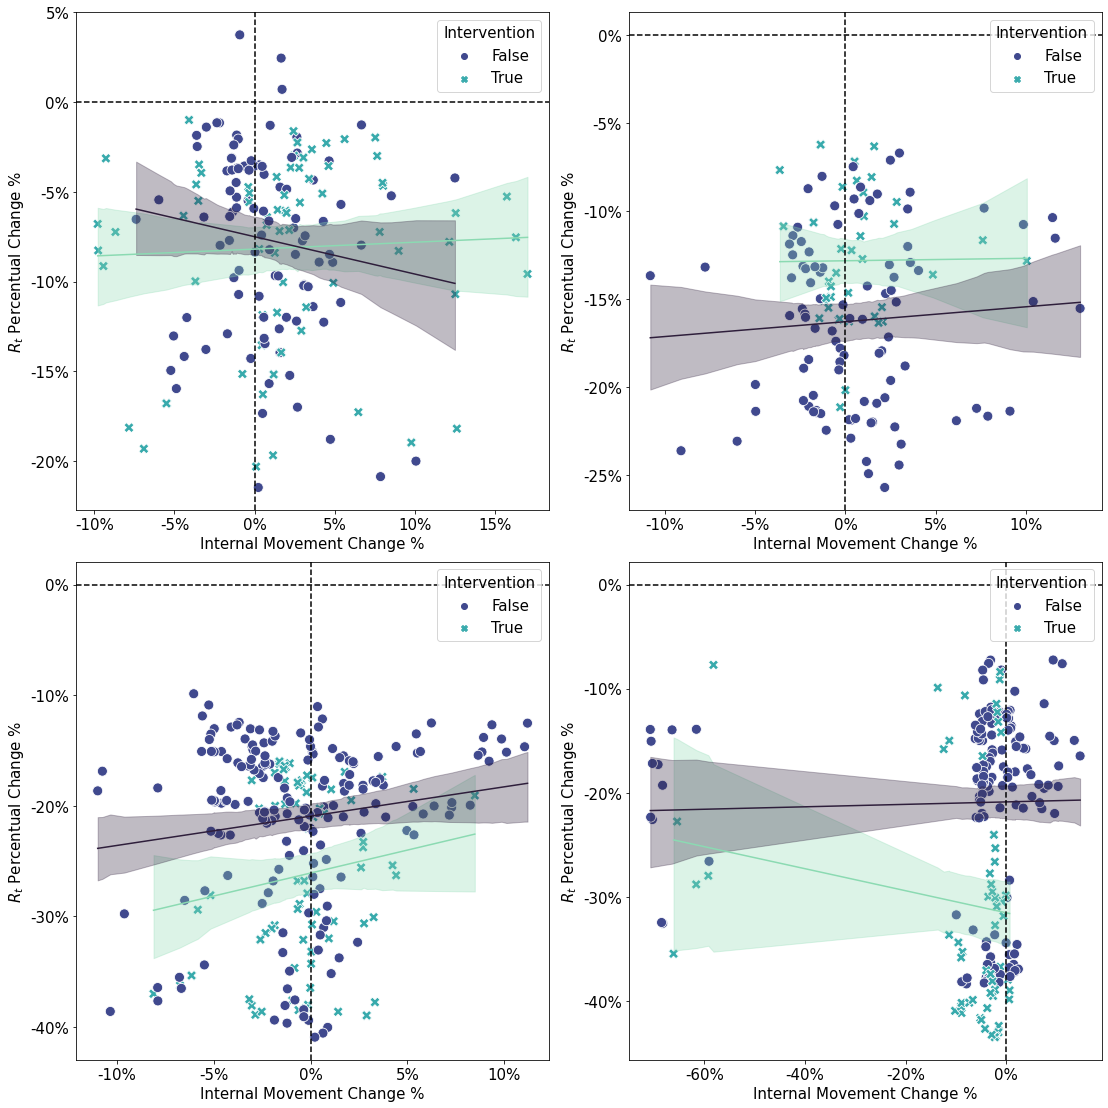

In [337]:

fig, ax = plt.subplots(2, 2, figsize=(15.5, 15.5), sharex=False)
sns.scatterplot(ax=ax[0,0], data=A_merged_df, x="internal", y="rt_percentage", hue="locked_down", style="locked_down", s=100, palette='mako')
ax[0,0].plot(df_resp_internal_A_lock["x"], df_resp_internal_A_lock["mean"], color=sns.color_palette("mako")[-1])
ax[0,0].fill_between(df_resp_internal_A_lock["x"], df_resp_internal_A_lock["low_95"], df_resp_internal_A_lock["high_95"], color=sns.color_palette("mako")[-1], alpha=0.3, interpolate=True)


ax[0,0].plot(df_resp_internal_A_nolock["x"], df_resp_internal_A_nolock["mean"], color=sns.color_palette("mako")[0])
ax[0,0].fill_between(df_resp_internal_A_nolock["x"], df_resp_internal_A_nolock["low_95"], df_resp_internal_A_nolock["high_95"], color=sns.color_palette("mako")[0], alpha=0.3, interpolate=True)


sns.scatterplot(ax=ax[0,1], data=B_merged_df, x="internal", y="rt_percentage", hue="locked_down", style="locked_down", s=100, palette='mako')
ax[0,1].plot(df_resp_internal_B_lock["x"], df_resp_internal_B_lock["mean"], color=sns.color_palette("mako")[-1])
ax[0,1].fill_between(df_resp_internal_B_lock["x"], df_resp_internal_B_lock["low_95"], df_resp_internal_B_lock["high_95"], color=sns.color_palette("mako")[-1], alpha=0.3, interpolate=True)
ax[0,1].plot(df_resp_internal_B_nolock["x"], df_resp_internal_B_nolock["mean"], color=sns.color_palette("mako")[0])
ax[0,1].fill_between(df_resp_internal_B_nolock["x"], df_resp_internal_B_nolock["low_95"], df_resp_internal_B_nolock["high_95"], color=sns.color_palette("mako")[0], alpha=0.3, interpolate=True)

sns.scatterplot(ax=ax[1,0], data=C_merged_df, x="internal", y="rt_percentage", hue="locked_down", style="locked_down", s=100, palette='mako')
ax[1,0].plot(df_resp_internal_C_lock["x"], df_resp_internal_C_lock["mean"], color=sns.color_palette("mako")[-1])
ax[1,0].fill_between(df_resp_internal_C_lock["x"], df_resp_internal_C_lock["low_95"], df_resp_internal_C_lock["high_95"], color=sns.color_palette("mako")[-1], alpha=0.3, interpolate=True)
ax[1,0].plot(df_resp_internal_C_nolock["x"], df_resp_internal_C_nolock["mean"], color=sns.color_palette("mako")[0])
ax[1,0].fill_between(df_resp_internal_C_nolock["x"], df_resp_internal_C_nolock["low_95"], df_resp_internal_C_nolock["high_95"], color=sns.color_palette("mako")[0], alpha=0.3, interpolate=True)


sns.scatterplot(ax=ax[1,1], data=D_merged_df, x="internal", y="rt_percentage", hue="locked_down", style="locked_down", s=100, palette='mako')
ax[1,1].plot(df_resp_internal_D_lock["x"], df_resp_internal_D_lock["mean"], color=sns.color_palette("mako")[-1])
ax[1,1].fill_between(df_resp_internal_D_lock["x"], df_resp_internal_D_lock["low_95"], df_resp_internal_D_lock["high_95"], color=sns.color_palette("mako")[-1], alpha=0.3, interpolate=True)
ax[1,1].plot(df_resp_internal_D_nolock["x"], df_resp_internal_D_nolock["mean"], color=sns.color_palette("mako")[0])
ax[1,1].fill_between(df_resp_internal_D_nolock["x"], df_resp_internal_D_nolock["low_95"], df_resp_internal_D_nolock["high_95"], color=sns.color_palette("mako")[0], alpha=0.3, interpolate=True)

for idx, axi in enumerate(ax.flatten()):
    lock = lockdowns[idx]
    axi.axhline(y=0, color='black', linestyle='--')
    axi.axvline(x=0, color='black', linestyle='--')
    axi.legend(loc='upper right', fontsize=15, title='Intervention', title_fontsize=15)
    axi.set_xlabel('Internal Movement Change %', fontsize=15)
    axi.set_ylabel(r'$R_t$ Percentual Change %', fontsize=15)
    axi.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))
    axi.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))
    axi.tick_params(axis='both', labelsize=15)

plt.tight_layout()
fig.savefig(os.path.join(results_dir, 'figures', 'internal_rt_scatter_bayesian_regression.png'), dpi=300,  bbox_inches='tight', transparent=True)


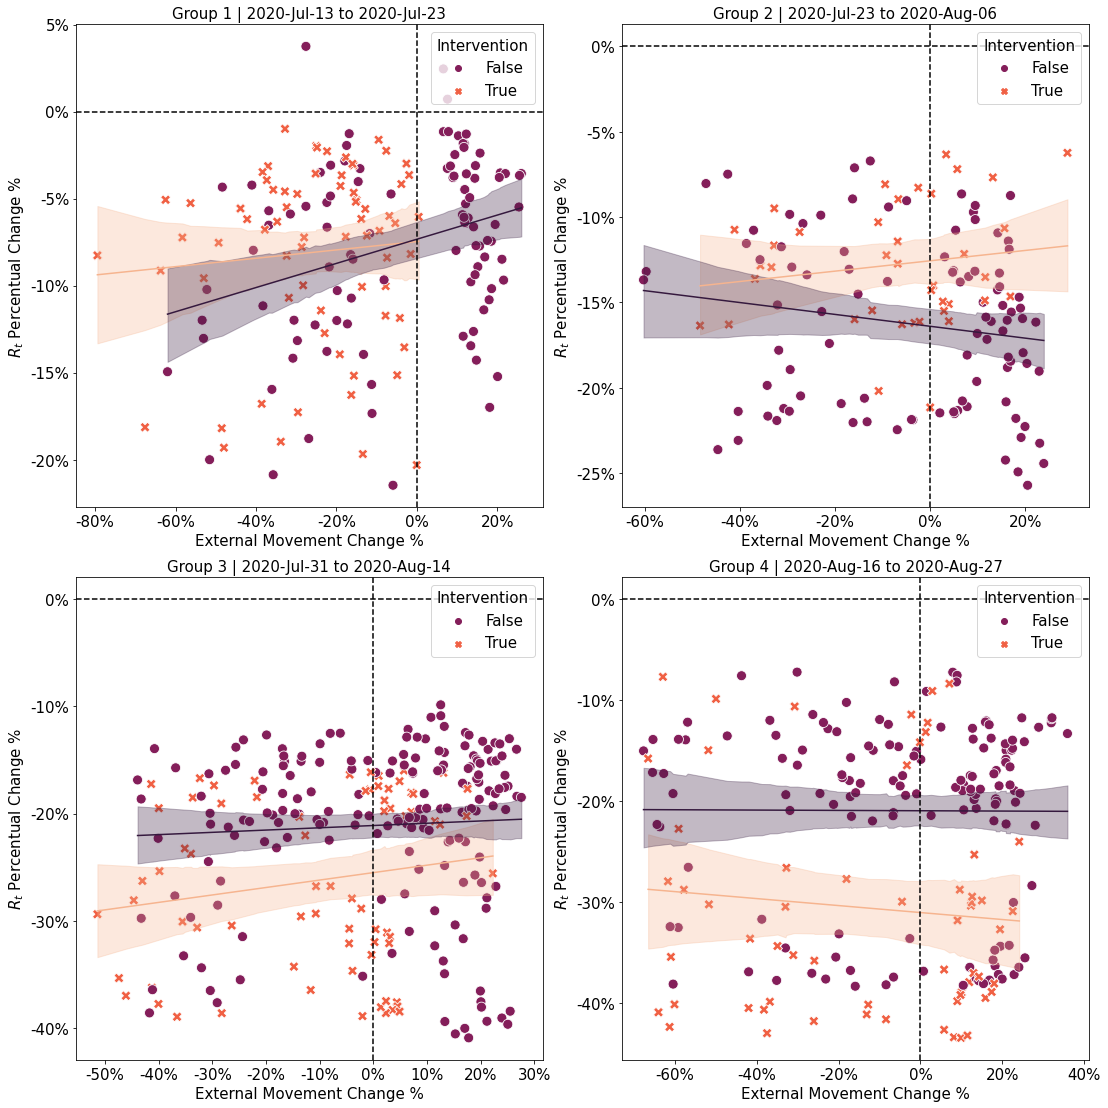

In [333]:
A_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'A']; A_merged_df = A_merged_df[A_merged_df["external"]>-0.95]
B_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'B']; B_merged_df = B_merged_df[B_merged_df["external"]>-0.95]
C_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'C']; C_merged_df = C_merged_df[C_merged_df["external"]>-0.95]
D_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'D']; D_merged_df = D_merged_df[D_merged_df["external"]>-0.95]



################ EXTERNAL ################
fig, ax = plt.subplots(2, 2, figsize=(15.5, 15.5), sharex=False)
sns.scatterplot(ax=ax[0,0], data=A_merged_df, x="external", y="rt_percentage", hue="locked_down", style="locked_down", s=100, palette='rocket')
ax[0,0].plot(df_resp_external_A_lock["x"], df_resp_external_A_lock["mean"], color=sns.color_palette("rocket")[-1])
ax[0,0].fill_between(df_resp_external_A_lock["x"], df_resp_external_A_lock["low_95"], df_resp_external_A_lock["high_95"], color=sns.color_palette("rocket")[-1], alpha=0.3, interpolate=True)


ax[0,0].plot(df_resp_external_A_nolock["x"], df_resp_external_A_nolock["mean"], color=sns.color_palette("rocket")[0])
ax[0,0].fill_between(df_resp_external_A_nolock["x"], df_resp_external_A_nolock["low_95"], df_resp_external_A_nolock["high_95"], color=sns.color_palette("rocket")[0], alpha=0.3, interpolate=True)


sns.scatterplot(ax=ax[0,1], data=B_merged_df, x="external", y="rt_percentage", hue="locked_down", style="locked_down", s=100, palette='rocket')
ax[0,1].plot(df_resp_external_B_lock["x"], df_resp_external_B_lock["mean"], color=sns.color_palette("rocket")[-1])
ax[0,1].fill_between(df_resp_external_B_lock["x"], df_resp_external_B_lock["low_95"], df_resp_external_B_lock["high_95"], color=sns.color_palette("rocket")[-1], alpha=0.3, interpolate=True)
ax[0,1].plot(df_resp_external_B_nolock["x"], df_resp_external_B_nolock["mean"], color=sns.color_palette("rocket")[0])
ax[0,1].fill_between(df_resp_external_B_nolock["x"], df_resp_external_B_nolock["low_95"], df_resp_external_B_nolock["high_95"], color=sns.color_palette("rocket")[0], alpha=0.3, interpolate=True)

sns.scatterplot(ax=ax[1,0], data=C_merged_df, x="external", y="rt_percentage", hue="locked_down", style="locked_down", s=100, palette='rocket')
ax[1,0].plot(df_resp_external_C_lock["x"], df_resp_external_C_lock["mean"], color=sns.color_palette("rocket")[-1])
ax[1,0].fill_between(df_resp_external_C_lock["x"], df_resp_external_C_lock["low_95"], df_resp_external_C_lock["high_95"], color=sns.color_palette("rocket")[-1], alpha=0.3, interpolate=True)
ax[1,0].plot(df_resp_external_C_nolock["x"], df_resp_external_C_nolock["mean"], color=sns.color_palette("rocket")[0])
ax[1,0].fill_between(df_resp_external_C_nolock["x"], df_resp_external_C_nolock["low_95"], df_resp_external_C_nolock["high_95"], color=sns.color_palette("rocket")[0], alpha=0.3, interpolate=True)


sns.scatterplot(ax=ax[1,1], data=D_merged_df, x="external", y="rt_percentage", hue="locked_down", style="locked_down", s=100, palette='rocket')
ax[1,1].plot(df_resp_external_D_lock["x"], df_resp_external_D_lock["mean"], color=sns.color_palette("rocket")[-1])
ax[1,1].fill_between(df_resp_external_D_lock["x"], df_resp_external_D_lock["low_95"], df_resp_external_D_lock["high_95"], color=sns.color_palette("rocket")[-1], alpha=0.3, interpolate=True)
ax[1,1].plot(df_resp_external_D_nolock["x"], df_resp_external_D_nolock["mean"], color=sns.color_palette("rocket")[0])
ax[1,1].fill_between(df_resp_external_D_nolock["x"], df_resp_external_D_nolock["low_95"], df_resp_external_D_nolock["high_95"], color=sns.color_palette("rocket")[0], alpha=0.3, interpolate=True)

codes_names = ['Group 1', 'Group 2', 'Group 3', 'Group 4']
for idx, axi in enumerate(ax.flatten()):
    lock = lockdowns[idx]
    axi.axhline(y=0, color='black', linestyle='--')
    axi.axvline(x=0, color='black', linestyle='--')
    axi.legend(loc='upper right', fontsize=15, title='Intervention', title_fontsize=15)
    axi.set_xlabel('External Movement Change %', fontsize=15)
    axi.set_ylabel(r'$R_t$ Percentual Change %', fontsize=15)
    axi.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))
    axi.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))
    axi.tick_params(axis='both', labelsize=15)

    axi.set_title(f"{codes_names[idx]} | {lock['start_date'].strftime('%Y-%b-%d')} to {lock['end_date'].strftime('%Y-%b-%d')}", fontsize=15)

plt.tight_layout()
fig.savefig(os.path.join(results_dir, 'figures', 'external_rt_scatter_bayesian_regression.png'), dpi=300,  bbox_inches='tight', transparent=True)



# Internal vs External

In [334]:

A_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'A']; A_merged_df = A_merged_df[A_merged_df["internal"]>-0.95]
B_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'B']; B_merged_df = B_merged_df[B_merged_df["internal"]>-0.95]
C_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'C']; C_merged_df = C_merged_df[C_merged_df["internal"]>-0.95]
D_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'D']; D_merged_df = D_merged_df[D_merged_df["internal"]>-0.95]

# A group
A_merged_lock_df   = A_merged_df[A_merged_df["locked_down"]==True]
A_merged_nolock_df = A_merged_df[A_merged_df["locked_down"]==False]
df_resp_internal_A_lock   = optimize_linear_model(A_merged_lock_df["internal"].values, A_merged_lock_df["external"].values, print_summary=False)
df_resp_internal_A_nolock = optimize_linear_model(A_merged_nolock_df["internal"].values, A_merged_nolock_df["external"].values, print_summary=False)

# B group
B_merged_lock_df   = B_merged_df[B_merged_df["locked_down"]==True]
B_merged_nolock_df = B_merged_df[B_merged_df["locked_down"]==False]
df_resp_internal_B_lock   = optimize_linear_model(B_merged_lock_df["internal"].values,   B_merged_lock_df["external"].values, print_summary=False)
df_resp_internal_B_nolock = optimize_linear_model(B_merged_nolock_df["internal"].values, B_merged_nolock_df["external"].values, print_summary=False)

# C group
C_merged_lock_df   = C_merged_df[C_merged_df["locked_down"]==True]
C_merged_nolock_df = C_merged_df[C_merged_df["locked_down"]==False]
df_resp_internal_C_lock   = optimize_linear_model(C_merged_lock_df["internal"].values,   C_merged_lock_df["external"].values, print_summary=False)
df_resp_internal_C_nolock = optimize_linear_model(C_merged_nolock_df["internal"].values, C_merged_nolock_df["external"].values, print_summary=False)

# D group
D_merged_lock_df   = D_merged_df[D_merged_df["locked_down"]==True]
D_merged_nolock_df = D_merged_df[D_merged_df["locked_down"]==False]
df_resp_internal_D_lock   = optimize_linear_model(D_merged_lock_df["internal"].values,   D_merged_lock_df["external"].values, print_summary=False)
df_resp_internal_D_nolock = optimize_linear_model(D_merged_nolock_df["internal"].values, D_merged_nolock_df["external"].values, print_summary=False)



sample: 100%|██████████| 3000/3000 [00:05<00:00, 513.55it/s, 3 steps of size 8.58e-01. acc. prob=0.89] 


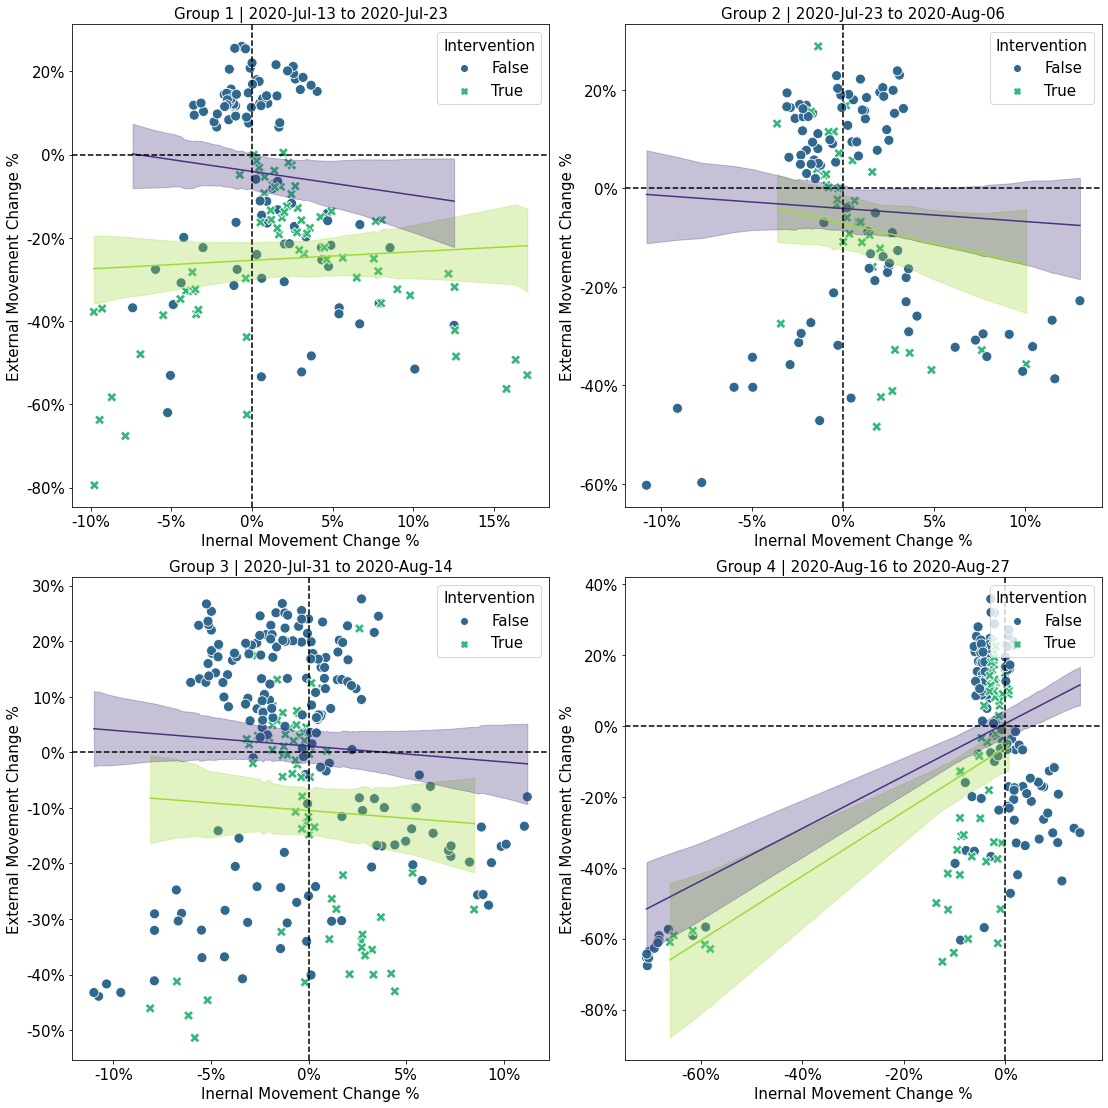

In [335]:
A_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'A']; A_merged_df = A_merged_df[A_merged_df["external"]>-0.95]
B_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'B']; B_merged_df = B_merged_df[B_merged_df["external"]>-0.95]
C_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'C']; C_merged_df = C_merged_df[C_merged_df["external"]>-0.95]
D_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'D']; D_merged_df = D_merged_df[D_merged_df["external"]>-0.95]



################ EXTERNAL ################
fig, ax = plt.subplots(2, 2, figsize=(15.5, 15.5), sharex=False)
sns.scatterplot(ax=ax[0,0], data=A_merged_df, x="internal", y="external", hue="locked_down", style="locked_down", s=100, palette='viridis')

ax[0,0].plot(df_resp_internal_A_lock["x"], df_resp_internal_A_lock["mean"], color=sns.color_palette("viridis")[-1])
ax[0,0].fill_between(df_resp_internal_A_lock["x"], df_resp_internal_A_lock["low_95"], df_resp_internal_A_lock["high_95"], color=sns.color_palette("viridis")[-1], alpha=0.3, interpolate=True)
ax[0,0].plot(df_resp_internal_A_nolock["x"], df_resp_internal_A_nolock["mean"], color=sns.color_palette("viridis")[0])
ax[0,0].fill_between(df_resp_internal_A_nolock["x"], df_resp_internal_A_nolock["low_95"], df_resp_internal_A_nolock["high_95"], color=sns.color_palette("viridis")[0], alpha=0.3, interpolate=True)


sns.scatterplot(ax=ax[0,1], data=B_merged_df, x="internal", y="external", hue="locked_down", style="locked_down", s=100, palette='viridis')
ax[0,1].plot(df_resp_internal_B_lock["x"], df_resp_internal_B_lock["mean"], color=sns.color_palette("viridis")[-1])
ax[0,1].fill_between(df_resp_internal_B_lock["x"], df_resp_internal_B_lock["low_95"], df_resp_internal_B_lock["high_95"], color=sns.color_palette("viridis")[-1], alpha=0.3, interpolate=True)
ax[0,1].plot(df_resp_internal_B_nolock["x"], df_resp_internal_B_nolock["mean"], color=sns.color_palette("viridis")[0])
ax[0,1].fill_between(df_resp_internal_B_nolock["x"], df_resp_internal_B_nolock["low_95"], df_resp_internal_B_nolock["high_95"], color=sns.color_palette("viridis")[0], alpha=0.3, interpolate=True)

sns.scatterplot(ax=ax[1,0], data=C_merged_df, x="internal", y="external", hue="locked_down", style="locked_down", s=100, palette='viridis')
ax[1,0].plot(df_resp_internal_C_lock["x"], df_resp_internal_C_lock["mean"], color=sns.color_palette("viridis")[-1])
ax[1,0].fill_between(df_resp_internal_C_lock["x"], df_resp_internal_C_lock["low_95"], df_resp_internal_C_lock["high_95"], color=sns.color_palette("viridis")[-1], alpha=0.3, interpolate=True)
ax[1,0].plot(df_resp_internal_C_nolock["x"], df_resp_internal_C_nolock["mean"], color=sns.color_palette("viridis")[0])
ax[1,0].fill_between(df_resp_internal_C_nolock["x"], df_resp_internal_C_nolock["low_95"], df_resp_internal_C_nolock["high_95"], color=sns.color_palette("viridis")[0], alpha=0.3, interpolate=True)


sns.scatterplot(ax=ax[1,1], data=D_merged_df, x="internal", y="external", hue="locked_down", style="locked_down", s=100, palette='viridis')
ax[1,1].plot(df_resp_internal_D_lock["x"], df_resp_internal_D_lock["mean"], color=sns.color_palette("viridis")[-1])
ax[1,1].fill_between(df_resp_internal_D_lock["x"], df_resp_internal_D_lock["low_95"], df_resp_internal_D_lock["high_95"], color=sns.color_palette("viridis")[-1], alpha=0.3, interpolate=True)
ax[1,1].plot(df_resp_internal_D_nolock["x"], df_resp_internal_D_nolock["mean"], color=sns.color_palette("viridis")[0])
ax[1,1].fill_between(df_resp_internal_D_nolock["x"], df_resp_internal_D_nolock["low_95"], df_resp_internal_D_nolock["high_95"], color=sns.color_palette("viridis")[0], alpha=0.3, interpolate=True)

codes_names = ['Group 1', 'Group 2', 'Group 3', 'Group 4']
for idx, axi in enumerate(ax.flatten()):
    lock = lockdowns[idx]
    axi.axhline(y=0, color='black', linestyle='--')
    axi.axvline(x=0, color='black', linestyle='--')
    axi.legend(loc='upper right', fontsize=15, title='Intervention', title_fontsize=15)
    axi.set_xlabel('Inernal Movement Change %', fontsize=15)
    axi.set_ylabel('External Movement Change %', fontsize=15)
    axi.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))
    axi.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))
    axi.tick_params(axis='both', labelsize=15)

    axi.set_title(f"{codes_names[idx]} | {lock['start_date'].strftime('%Y-%b-%d')} to {lock['end_date'].strftime('%Y-%b-%d')}", fontsize=15)

plt.tight_layout()
fig.savefig(os.path.join(results_dir, 'figures', 'internal_external_scatter_bayesian_regression.png'), dpi=300,  bbox_inches='tight', transparent=True)



#  bineando por semana.

In [356]:
A_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'A']; A_merged_df = A_merged_df[A_merged_df["external"]>-0.95]
B_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'B']; B_merged_df = B_merged_df[B_merged_df["external"]>-0.95]
C_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'C']; C_merged_df = C_merged_df[C_merged_df["external"]>-0.95]
D_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'D']; D_merged_df = D_merged_df[D_merged_df["external"]>-0.95]

A_merged_df = A_merged_df.groupby([ "location_id", "locked_down", pd.Grouper(key='date', freq='W-SUN')])["external", "internal", "rt_percentage"].mean().reset_index()
B_merged_df = B_merged_df.groupby([ "location_id", "locked_down", pd.Grouper(key='date', freq='W-SUN')])["external", "internal", "rt_percentage"].mean().reset_index()
C_merged_df = C_merged_df.groupby([ "location_id", "locked_down", pd.Grouper(key='date', freq='W-SUN')])["external", "internal", "rt_percentage"].mean().reset_index()
D_merged_df = D_merged_df.groupby([ "location_id", "locked_down", pd.Grouper(key='date', freq='W-SUN')])["external", "internal", "rt_percentage"].mean().reset_index()


A_merged_lock_df   = A_merged_df[A_merged_df["locked_down"]==True]
A_merged_nolock_df = A_merged_df[A_merged_df["locked_down"]==False]
B_merged_lock_df   = B_merged_df[B_merged_df["locked_down"]==True]
B_merged_nolock_df = B_merged_df[B_merged_df["locked_down"]==False]
C_merged_lock_df   = C_merged_df[C_merged_df["locked_down"]==True]
C_merged_nolock_df = C_merged_df[C_merged_df["locked_down"]==False]
D_merged_lock_df   = D_merged_df[D_merged_df["locked_down"]==True]
D_merged_nolock_df = D_merged_df[D_merged_df["locked_down"]==False]


# A group
df_resp_external_A_lock   = optimize_linear_model(A_merged_lock_df["external"].values, A_merged_lock_df["rt_percentage"].values, print_summary=False)
df_resp_external_A_nolock = optimize_linear_model(A_merged_nolock_df["external"].values, A_merged_nolock_df["rt_percentage"].values, print_summary=False)
df_resp_internal_A_lock   = optimize_linear_model(A_merged_lock_df["internal"].values, A_merged_lock_df["rt_percentage"].values, print_summary=False)
df_resp_internal_A_nolock = optimize_linear_model(A_merged_nolock_df["internal"].values, A_merged_nolock_df["rt_percentage"].values, print_summary=False)

# B group
df_resp_external_B_lock   = optimize_linear_model(B_merged_lock_df["external"].values,   B_merged_lock_df["rt_percentage"].values, print_summary=False)
df_resp_external_B_nolock = optimize_linear_model(B_merged_nolock_df["external"].values, B_merged_nolock_df["rt_percentage"].values, print_summary=False)
df_resp_internal_B_lock   = optimize_linear_model(B_merged_lock_df["internal"].values,   B_merged_lock_df["rt_percentage"].values, print_summary=False)
df_resp_internal_B_nolock = optimize_linear_model(B_merged_nolock_df["internal"].values, B_merged_nolock_df["rt_percentage"].values, print_summary=False)

# C group
df_resp_external_C_lock   = optimize_linear_model(C_merged_lock_df["external"].values,   C_merged_lock_df["rt_percentage"].values, print_summary=False)
df_resp_external_C_nolock = optimize_linear_model(C_merged_nolock_df["external"].values, C_merged_nolock_df["rt_percentage"].values, print_summary=False)

df_resp_internal_C_lock   = optimize_linear_model(C_merged_lock_df["internal"].values,   C_merged_lock_df["rt_percentage"].values, print_summary=False)
df_resp_internal_C_nolock = optimize_linear_model(C_merged_nolock_df["internal"].values, C_merged_nolock_df["rt_percentage"].values, print_summary=False)

# D group
df_resp_external_D_lock   = optimize_linear_model(D_merged_lock_df["external"].values,   D_merged_lock_df["rt_percentage"].values, print_summary=False)
df_resp_external_D_nolock = optimize_linear_model(D_merged_nolock_df["external"].values, D_merged_nolock_df["rt_percentage"].values, print_summary=False)
df_resp_internal_D_lock   = optimize_linear_model(D_merged_lock_df["internal"].values,   D_merged_lock_df["rt_percentage"].values, print_summary=False)
df_resp_internal_D_nolock = optimize_linear_model(D_merged_nolock_df["internal"].values, D_merged_nolock_df["rt_percentage"].values, print_summary=False)


<ipython-input-356-1dba1d0a5075>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  A_merged_df = A_merged_df.groupby([ "location_id", "locked_down", pd.Grouper(key='date', freq='W-SUN')])["external", "internal", "rt_percentage"].mean().reset_index()
<ipython-input-356-1dba1d0a5075>:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  B_merged_df = B_merged_df.groupby([ "location_id", "locked_down", pd.Grouper(key='date', freq='W-SUN')])["external", "internal", "rt_percentage"].mean().reset_index()
<ipython-input-356-1dba1d0a5075>:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  C_merged_df = C_merged_df.groupby([ "location_id", "locked_down", pd.Grouper(key='date', freq='W-SUN')])["external", "internal", "rt_percentage"].mean().reset_index()
<ipython-i

IndexError: too many indices for array: array is 1-dimensional, but 14 were indexed

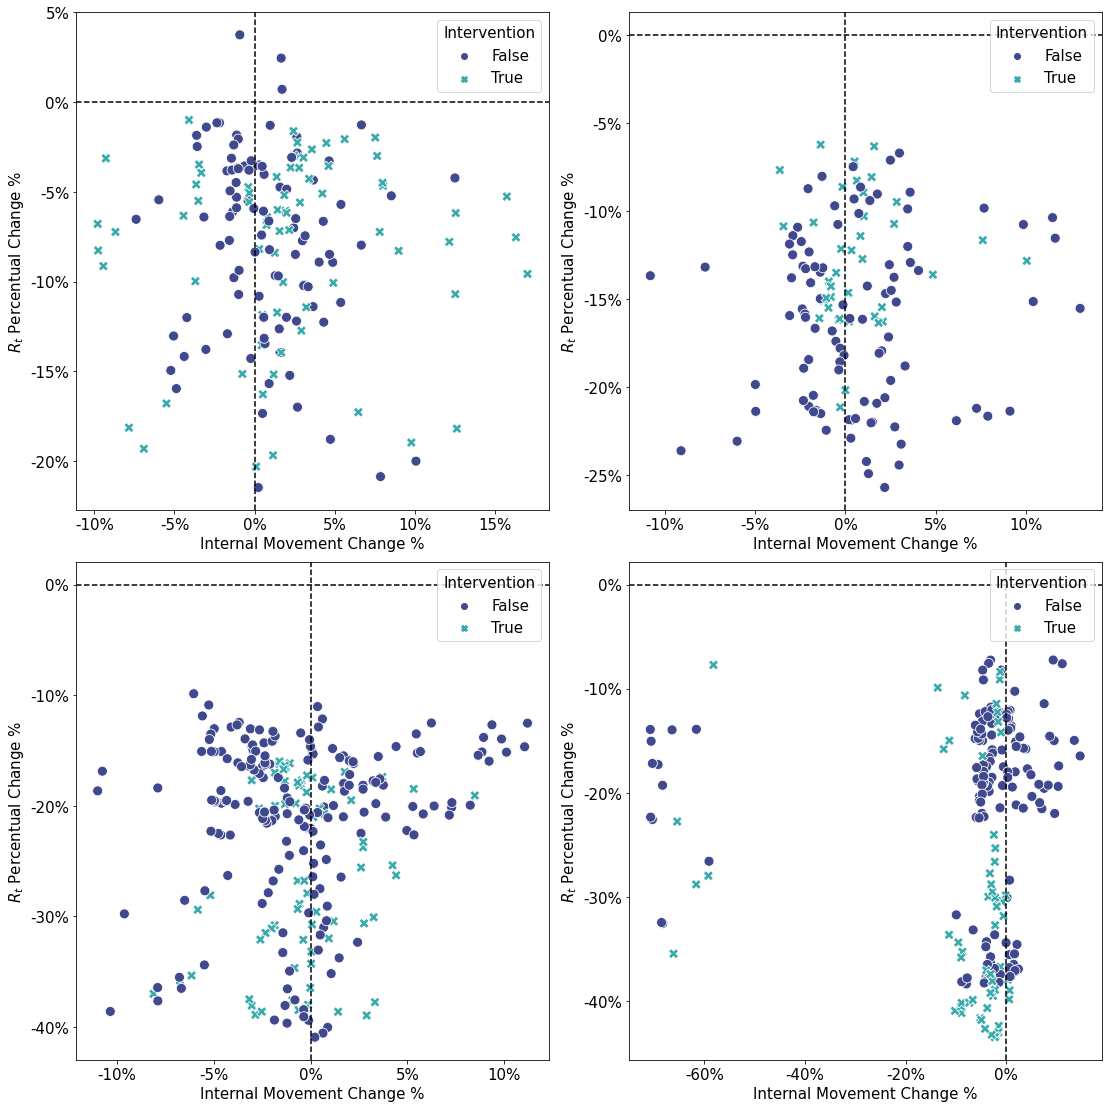

In [360]:

fig, ax = plt.subplots(2, 2, figsize=(15.5, 15.5), sharex=False)
sns.scatterplot(ax=ax[0,0], data=A_merged_df, x="internal", y="rt_percentage", hue="locked_down", style="locked_down", s=100, palette='mako')
sns.scatterplot(ax=ax[0,1], data=B_merged_df, x="internal", y="rt_percentage", hue="locked_down", style="locked_down", s=100, palette='mako')
sns.scatterplot(ax=ax[1,0], data=C_merged_df, x="internal", y="rt_percentage", hue="locked_down", style="locked_down", s=100, palette='mako')
sns.scatterplot(ax=ax[1,1], data=D_merged_df, x="internal", y="rt_percentage", hue="locked_down", style="locked_down", s=100, palette='mako')

for idx, axi in enumerate(ax.flatten()):
    lock = lockdowns[idx]
    axi.axhline(y=0, color='black', linestyle='--')
    axi.axvline(x=0, color='black', linestyle='--')
    axi.legend(loc='upper right', fontsize=15, title='Intervention', title_fontsize=15)
    axi.set_xlabel('Internal Movement Change %', fontsize=15)
    axi.set_ylabel(r'$R_t$ Percentual Change %', fontsize=15)
    axi.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))
    axi.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))
    axi.tick_params(axis='both', labelsize=15)

plt.tight_layout()
fig.savefig(os.path.join(results_dir, 'figures', 'internal_rt_scatter_bayesian_regression_weekly.png'), dpi=300,  bbox_inches='tight', transparent=True)


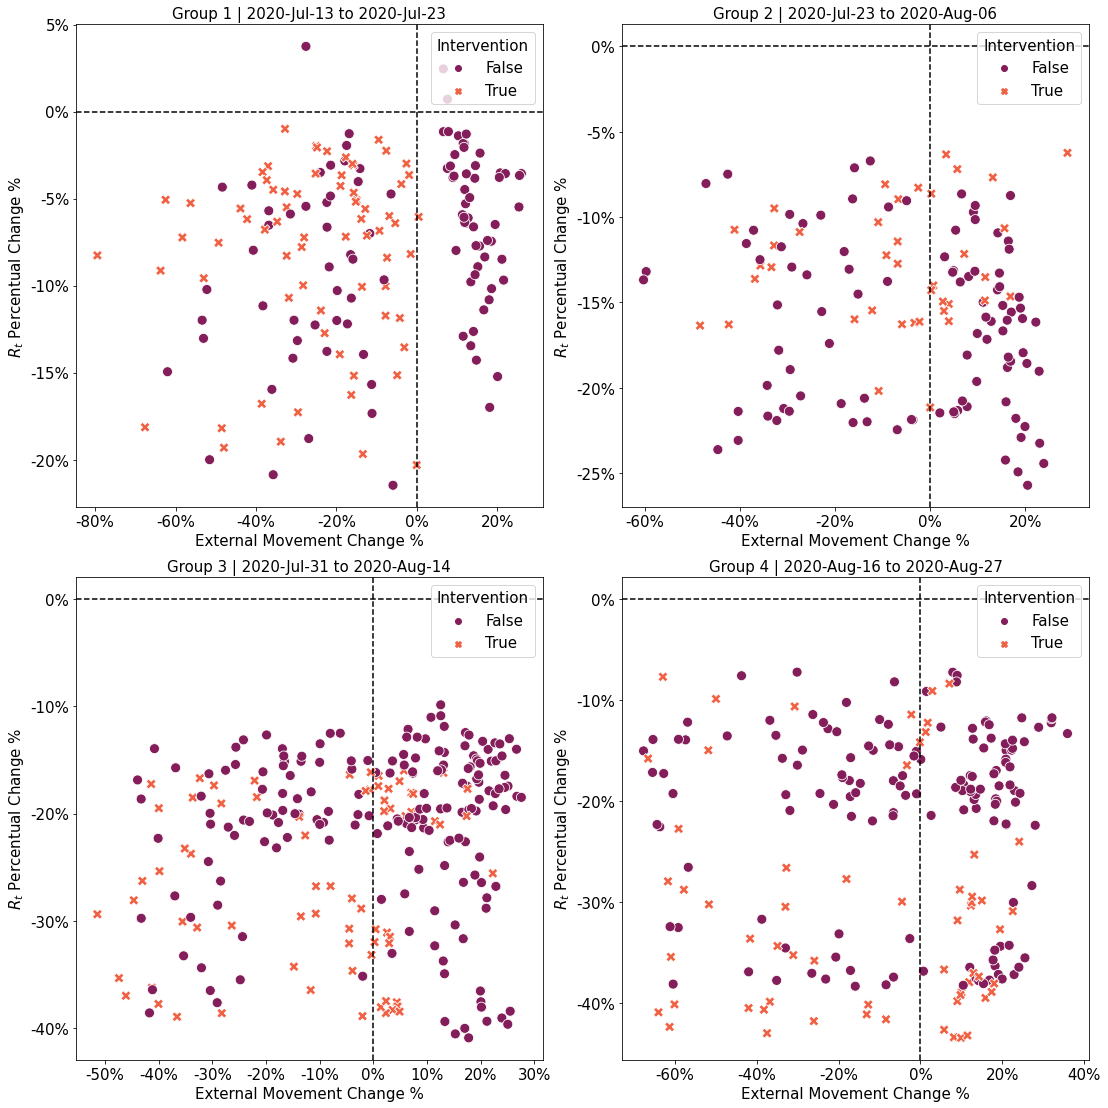

In [359]:

A_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'A']; A_merged_df = A_merged_df[A_merged_df["external"]>-0.95]
B_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'B']; B_merged_df = B_merged_df[B_merged_df["external"]>-0.95]
C_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'C']; C_merged_df = C_merged_df[C_merged_df["external"]>-0.95]
D_merged_df =  all_data_merged[all_data_merged.lockdown_group== 'D']; D_merged_df = D_merged_df[D_merged_df["external"]>-0.95]



################ EXTERNAL ################
fig, ax = plt.subplots(2, 2, figsize=(15.5, 15.5), sharex=False)
sns.scatterplot(ax=ax[0,0], data=A_merged_df, x="external", y="rt_percentage", hue="locked_down", style="locked_down", s=100, palette='rocket')
sns.scatterplot(ax=ax[0,1], data=B_merged_df, x="external", y="rt_percentage", hue="locked_down", style="locked_down", s=100, palette='rocket')
sns.scatterplot(ax=ax[1,0], data=C_merged_df, x="external", y="rt_percentage", hue="locked_down", style="locked_down", s=100, palette='rocket')
sns.scatterplot(ax=ax[1,1], data=D_merged_df, x="external", y="rt_percentage", hue="locked_down", style="locked_down", s=100, palette='rocket')

codes_names = ['Group 1', 'Group 2', 'Group 3', 'Group 4']
for idx, axi in enumerate(ax.flatten()):
    lock = lockdowns[idx]
    axi.axhline(y=0, color='black', linestyle='--')
    axi.axvline(x=0, color='black', linestyle='--')
    axi.legend(loc='upper right', fontsize=15, title='Intervention', title_fontsize=15)
    axi.set_xlabel('External Movement Change %', fontsize=15)
    axi.set_ylabel(r'$R_t$ Percentual Change %', fontsize=15)
    axi.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))
    axi.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0%}"))
    axi.tick_params(axis='both', labelsize=15)

    axi.set_title(f"{codes_names[idx]} | {lock['start_date'].strftime('%Y-%b-%d')} to {lock['end_date'].strftime('%Y-%b-%d')}", fontsize=15)

plt.tight_layout()
fig.savefig(os.path.join(results_dir, 'figures', 'external_rt_scatter_bayesian_regression_weekly.png'), dpi=300,  bbox_inches='tight', transparent=True)


